In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function, absolute_import, division

In [3]:
import numpy as np
from GomokuBoard import GomokuBoard
from GomokuTools import NH9x9, Heuristics, GomokuTools as gt

In [4]:
A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U = \
    1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
BLACK=0
WHITE=1
EDGES=2

## Single line scores

```Heuristics``` pre-computes all counts and scores a initialization time 

In [5]:
h = Heuristics()

Displaying the relevance count, which is a function of the number of offensive stones, their density, and open-ended-ness. Also displaying the score which adds some more fine-grained heuristic relevance aspects.

In [6]:
for i in [
    '.......x',
    '.....xo.',
    '....xo..',
    '......x.',
    '....x...',
    '...x..x.',
    '...x.x..',
    '...xx...',
    '..x.xx..',
    'o.o.xxx.',]:
    print(i, h.lookup_count(*gt.line_for_xo(i)), h.lookup_score(*gt.line_for_xo(i)))

.......x 0 80
.....xo. 0 82
....xo.. 0 83
......x. 1 337
....x... 1 339
...x..x. 2 596
...x.x.. 3 853
...xx... 4 1110
..x.xx.. 5 1367
o.o.xxx. 11 2902


## Multi-line (neighbourhood) scores

In [7]:
h.nhcombine(np.array([[[6,6,0,0]]]), kappa=2.0)

array([[8.48528137]])

---
Some tools for visualization

In [8]:
def nhforxo(e,ne='........', n='........', nw='........'):
    """
    Neighbourhood from xo-strings
    """
    lines = np.array([gt.line_for_xo(xo) for xo in [e,ne,n,nw]])
    lines = np.rollaxis(lines, 1, 0)
    return NH9x9(*lines)

In [9]:
def dsc(h, e,ne='........',n='........', nw='........', kappa=1.2):
    """
    Display the neighbourhood and its score
    """
    counts = [h.lookup_count(*gt.line_for_xo(s)) for s in [e,ne,n,nw]]
    print(counts, h.nhcombine(np.array([[counts]]),kappa=kappa))
    print(nhforxo(e,ne,n,nw))

---

#### Not strictly dangerous, yet.

In [10]:
dsc(h, '.....xxx')

[5, 0, 0, 0] [[5.]]
|                 |
|                 |
|                 |
|                 |
|        *   x x x|
|                 |
|                 |
|                 |
|                 |


In [11]:
dsc(h, '...xx..o', '...x.xo.')

[4, 2, 0, 0] [[5.40554303]]
|                 |
|              o  |
|            x    |
|                 |
|      x * x     o|
|      x          |
|                 |
|                 |
|                 |


In [12]:
dsc(h, '...xxxo.','..x.....')

[5, 1, 0, 0] [[5.59706883]]
|                 |
|                 |
|                 |
|                 |
|      x * x x o  |
|                 |
|    x            |
|                 |
|                 |


#### Immediate action required: count > 6

In [13]:
dsc(h, '...xx..o', '...x.x..')

[4, 3, 0, 0] [[6.24904694]]
|                 |
|                 |
|            x    |
|                 |
|      x * x     o|
|      x          |
|                 |
|                 |
|                 |


In [14]:
dsc(h, '...xx..o', '...xx...')

[4, 4, 0, 0] [[7.12718975]]
|                 |
|                 |
|                 |
|          x      |
|      x * x     o|
|      x          |
|                 |
|                 |
|                 |


In [15]:
dsc(h, '...xxxo.','.xx.....')

[5, 4, 0, 0] [[8.02800084]]
|                 |
|                 |
|                 |
|                 |
|      x * x x o  |
|                 |
|    x            |
|  x              |
|                 |


#### Fatal

In [16]:
dsc(h, '...xxx.o')

[11, 0, 0, 0] [[11.]]
|                 |
|                 |
|                 |
|                 |
|      x * x x   o|
|                 |
|                 |
|                 |
|                 |


---
## Scoring the entire board

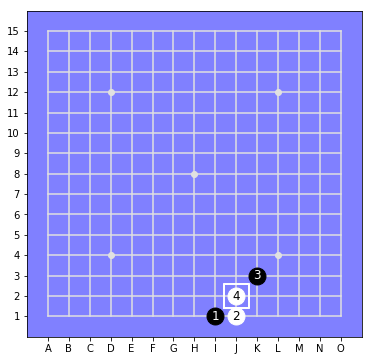

In [17]:
board=GomokuBoard()
board.set(I,1).set(J,1).set(K,3).set(J,2).display()

We'll be looking at the neighbourhood of position (J,3).

In [18]:
board.getnh(J,3)

|                 |
|                 |
|                 |
|                 |
|        * x      |
|        o        |
|        o        |
|  +     +     +  |
|                 |

In [19]:
board.lines[0][12][9], board.lines[1][12][9], board.lines[2][12][9]

(array([8, 0, 0, 0]), array([ 0,  0, 48,  0]), array([ 0, 64, 64, 64]))

#### Black's perspective

Calculating indices for the count/score lookup

In [20]:
b_indices = 256*board.lines[0]+(board.lines[1] | board.lines[2])

In [21]:
b_indices.shape

(15, 15, 4)

Noticed? This is lookup by array: super-efficient!

In [22]:
b_scores = h._all_scores[b_indices]
b_counts = h._all_counts[b_indices]

In [23]:
b_counts.shape

(15, 15, 4)

In [24]:
# This is position (J,3): a single black stone on the eastern line
b_counts[12][9]

array([1, 0, 0, 0])

#### White's perspective

In [25]:
w_indices = 256*board.lines[1]+(board.lines[0] | board.lines[2])

In [26]:
w_scores = h._all_scores[w_indices]
w_counts = h._all_counts[w_indices]

In [27]:
# This is position (J,3) - two stones facing north with one open end
w_counts[12][9]

array([0, 0, 3, 0])

In [28]:
# compare: two stones, one open end
h.lookup_count(*gt.line_for_xo('.oxx....'))

3

In [29]:
allnhscores = h.nhcombine(w_counts)

In [30]:
allnhscores[12][9]

3.0

#### Implementation in ```GomokuField```

In [31]:
board.compute_all_counts_and_scores()

In [32]:
board.get_count(1,J,3)

3.0

In [33]:
board.counts[1].shape

(15, 15)